# Multi-Stock LSTM Prediction Model
This notebook trains a universal LSTM that predicts stock direction and returns for multiple stocks.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [2]:
!pip install tensorflow

In [3]:
TICKERS = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS']

def download_stock_data(tickers, start='2015-01-01'):
    # Download all tickers together (includes Open, High, Low, Close, Adj Close, Volume)
    data = yf.download(tickers, start=start, group_by='ticker', auto_adjust=False)

    # Flatten multi-index columns (Date as index, Ticker as second level)
    df_list = []
    for ticker in tickers:
        temp = data[ticker].copy()
        temp['Ticker'] = ticker
        df_list.append(temp)

    # Combine all tickers into one DataFrame
    df = pd.concat(df_list)
    df.reset_index(inplace=True)

    return df

# Download and preview
df_raw = download_stock_data(TICKERS)
df_raw.to_csv('multi_stock_data.csv', index=False)
files.download('multi_stock_data.csv')
df_raw.tail()

[*********************100%***********************]  5 of 5 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Price,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
13345,2025-10-17,1412.000000,1439.599976,1410.900024,1436.599976,1436.599976,17037215,ICICIBANK.NS
13346,2025-10-20,1442.000000,1445.000000,1389.199951,1390.300049,1390.300049,23330227,ICICIBANK.NS
13347,2025-10-21,1384.500000,1387.599976,1375.900024,1382.000000,1382.000000,3415560,ICICIBANK.NS
13348,2025-10-23,1385.000000,1389.800049,1360.099976,1363.699951,1363.699951,21124942,ICICIBANK.NS
13349,2025-10-24,1368.099976,1381.599976,1368.099976,1377.699951,1377.699951,10570263,ICICIBANK.NS


In [4]:
def feature_engineering(df):
    df['Return'] = df['Adj Close'].pct_change()
    df['MA_5'] = df['Adj Close'].rolling(5).mean()
    df['MA_10'] = df['Adj Close'].rolling(10).mean()
    df['Volatility_10'] = df['Return'].rolling(10).std()
    df['Momentum'] = df['Adj Close'] / df['Adj Close'].shift(5) - 1
    df['MA_Ratio'] = df['MA_5'] / df['MA_10'] - 1
    df = df.dropna()
    df['Target_Class'] = (df['Return'].shift(-1) > 0).astype(int)
    df['Target_Reg'] = df['Return'].shift(-1)
    return df.dropna()

df_feat = feature_engineering(df_raw)
df_feat.tail()

/tmp/ipython-input-414077471.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target_Class'] = (df['Return'].shift(-1) > 0).astype(int)
/tmp/ipython-input-414077471.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target_Reg'] = df['Return'].shift(-1)


Price,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Return,MA_5,MA_10,Volatility_10,Momentum,MA_Ratio,Target_Class,Target_Reg
13344,2025-10-16,1401.0,1418.900024,1399.400024,1417.300049,1417.300049,12185032,ICICIBANK.NS,0.013515,1391.900024,1381.050012,0.006225,0.029865,0.007856,1,0.013617
13345,2025-10-17,1412.0,1439.599976,1410.900024,1436.599976,1436.599976,17037215,ICICIBANK.NS,0.013617,1403.160010,1388.190015,0.006268,0.040788,0.010784,0,-0.032229
13346,2025-10-20,1442.0,1445.000000,1389.199951,1390.300049,1390.300049,23330227,ICICIBANK.NS,-0.032229,1405.340015,1390.880017,0.013384,0.007902,0.010396,0,-0.005970
13347,2025-10-21,1384.5,1387.599976,1375.900024,1382.000000,1382.000000,3415560,ICICIBANK.NS,-0.005970,1404.920020,1391.490015,0.013344,-0.001517,0.009652,0,-0.013242
13348,2025-10-23,1385.0,1389.800049,1360.099976,1363.699951,1363.699951,21124942,ICICIBANK.NS,-0.013242,1397.980005,1390.830005,0.013994,-0.024814,0.005141,1,0.010266


In [5]:
SEQ_LEN = 30
FEATURE_COLS = ['Return', 'MA_5', 'MA_10', 'Volatility_10', 'Momentum', 'MA_Ratio']

def create_sequences_multi(df, seq_len=SEQ_LEN):
    X_seq, y_class, y_reg, stock_ids = [], [], [], []
    le = LabelEncoder()
    df['Ticker_ID'] = le.fit_transform(df['Ticker'])

    for ticker, subdf in df.groupby('Ticker'):
        arr = subdf[FEATURE_COLS].values
        cls = subdf['Target_Class'].values
        reg = subdf['Target_Reg'].values
        tid = subdf['Ticker_ID'].iloc[0]

        for i in range(len(subdf) - seq_len):
            X_seq.append(arr[i:i+seq_len])
            y_class.append(cls[i+seq_len])
            y_reg.append(reg[i+seq_len])
            stock_ids.append(tid)

    return np.array(X_seq), np.array(y_class), np.array(y_reg), np.array(stock_ids), le

X, y_class, y_reg, stock_ids, le = create_sequences_multi(df_feat)
print('X shape:', X.shape, 'Stock IDs:', len(np.unique(stock_ids)))

X shape: (13189, 30, 6) Stock IDs: 5


In [6]:
scaler = StandardScaler()
num_samples, seq_len, num_feats = X.shape
X = X.reshape(-1, num_feats)
X = scaler.fit_transform(X)
X = X.reshape(num_samples, seq_len, num_feats)

In [7]:
def build_multi_stock_model(seq_len, num_feats, num_stocks, embed_dim=4):
    price_input = Input(shape=(seq_len, num_feats), name='price_input')
    stock_input = Input(shape=(1,), name='stock_input')

    embed = Embedding(num_stocks, embed_dim)(stock_input)
    embed_flat = Dense(embed_dim, activation='relu')(embed)
    embed_flat = Dropout(0.1)(embed_flat)

    lstm_out = LSTM(64, return_sequences=False)(price_input)
    merged = Concatenate()([lstm_out, embed_flat[:, 0, :]])

    dense1 = Dense(64, activation='relu')(merged)
    drop1 = Dropout(0.2)(dense1)

    class_output = Dense(1, activation='sigmoid', name='class_output')(drop1)
    reg_output = Dense(1, activation='linear', name='reg_output')(drop1)

    model = Model(inputs=[price_input, stock_input],
                  outputs=[class_output, reg_output])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'class_output': 'binary_crossentropy', 'reg_output': 'mse'},
        loss_weights={'class_output': 1.0, 'reg_output': 0.5},
        metrics={'class_output': 'accuracy', 'reg_output': 'mae'}
    )
    return model

model = build_multi_stock_model(SEQ_LEN, len(FEATURE_COLS), len(np.unique(stock_ids)))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ stock_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 4)      │         20 │ stock_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 4)      │         20 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_input         │ (None, 30, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 4)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     18,176 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 4)         │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 68)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reg_output (Dense)  │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,762 (88.91 KB)

 Trainable params: 22,762 (88.91 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    [X, stock_ids],
    {'class_output': y_class, 'reg_output': y_reg},
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early],
    verbose=1
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - class_output_accuracy: 0.5115 - class_output_loss: 0.6937 - loss: 0.6954 - reg_output_loss: 0.0035 - reg_output_mae: 0.0398 - val_class_output_accuracy: 0.5045 - val_class_output_loss: 0.6958 - val_loss: 0.6960 - val_reg_output_loss: 0.0020 - val_reg_output_mae: 0.0204
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - class_output_accuracy: 0.5161 - class_output_loss: 0.6921 - loss: 0.6926 - reg_output_loss: 9.8910e-04 - reg_output_mae: 0.0206 - val_class_output_accuracy: 0.5118 - val_class_output_loss: 0.6949 - val_loss: 0.6953 - val_reg_output_loss: 0.0017 - val_reg_output_mae: 0.0163
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - class_output_accuracy: 0.5211 - class_output_loss: 0.6915 - loss: 0.6919 - reg_output_loss: 6.7296e-04 - reg_output_mae: 0.0170 - val_class_output_accuracy: 0.5076 - val_class_output_loss: 0.6969 - val_loss: 0.6982 - val_reg_output_loss: 0.0032 - val_reg_output_mae: 0.0364
Epoch 4/20
165/1

📈 TCS.NS Prediction: DOWN, Expected Return: -1.34%


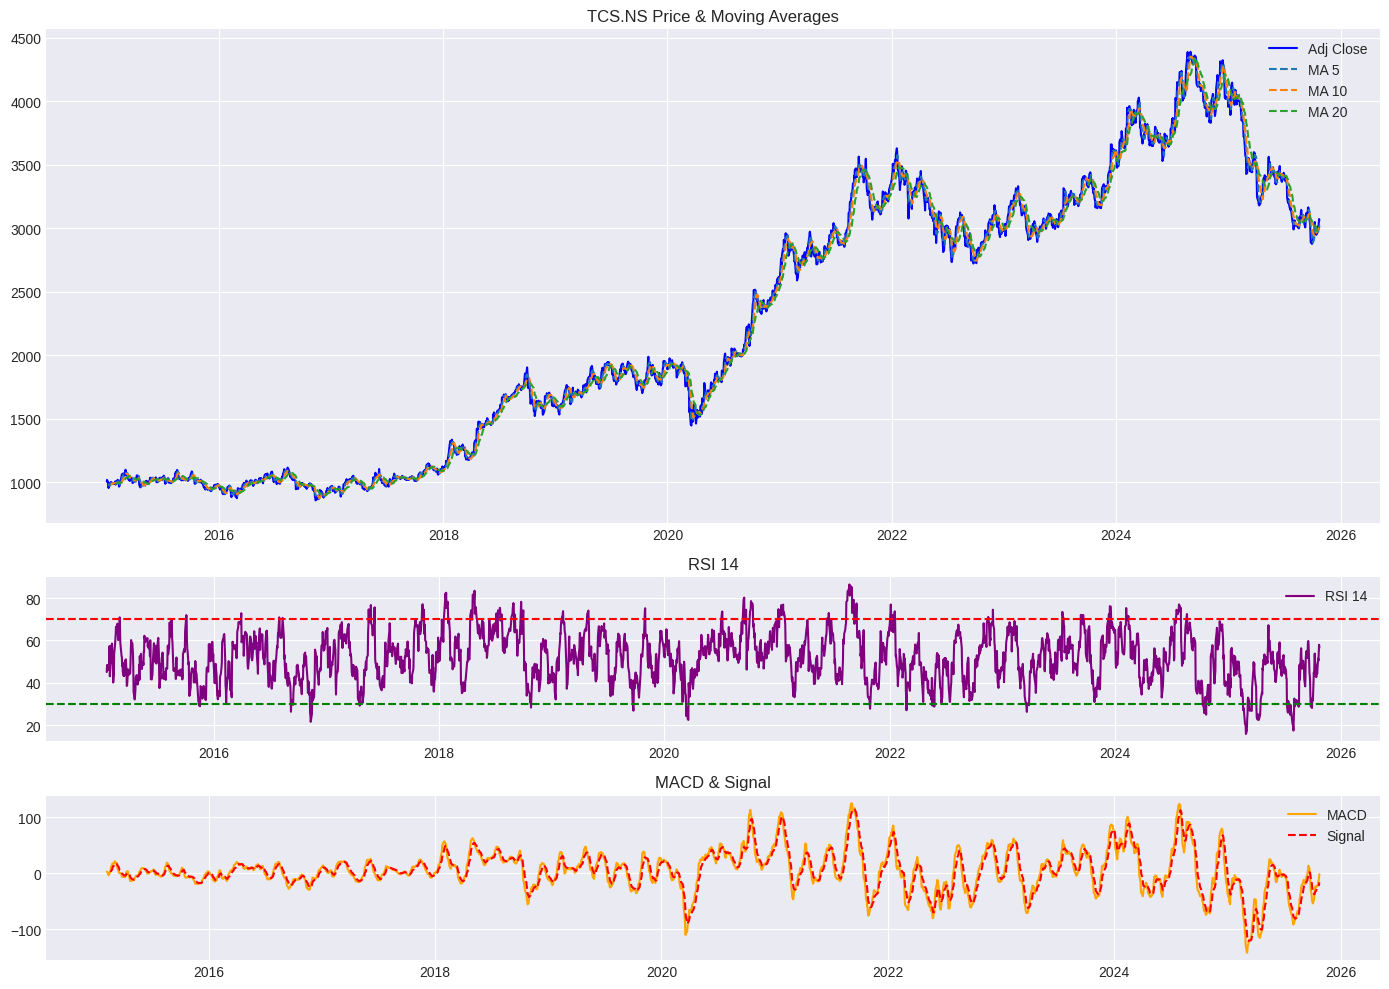

In [17]:
def predict_for_stock(ticker):
    tid = le.transform([ticker])[0]
    df_sub = df_feat[df_feat['Ticker'] == ticker].copy()
    X_pred, _, _, _, _ = create_sequences_multi(df_sub)
    X_pred = X_pred.reshape(-1, SEQ_LEN, len(FEATURE_COLS))
    X_pred = scaler.transform(X_pred.reshape(-1, len(FEATURE_COLS))).reshape(-1, SEQ_LEN, len(FEATURE_COLS))
    stock_array = np.full((len(X_pred), 1), tid)
    preds_class, preds_reg = model.predict([X_pred, stock_array], verbose=0)

    last_pred_dir = 'UP' if preds_class[-1][0] > 0.5 else 'DOWN'
    last_pred_ret = preds_reg[-1][0] * 100
    print(f'📈 {ticker} Prediction: {last_pred_dir}, Expected Return: {last_pred_ret:.2f}%')

predict_for_stock('HDFCBANK.NS')
predict_for_stock('INFY.NS')
predict_for_stock('RELIANCE.NS')

In [ ]:
import matplotlib.pyplot as plt
import ta

def predict_and_plot_stock(ticker):
    # --- Prediction ---
    tid = le.transform([ticker])[0]
    df_sub = df_feat[df_feat['Ticker'] == ticker].copy()

    # Create sequences for prediction
    X_pred, _, _, _, _ = create_sequences_multi(df_sub)
    X_pred = scaler.transform(X_pred.reshape(-1, len(FEATURE_COLS))).reshape(-1, SEQ_LEN, len(FEATURE_COLS))
    stock_array = np.full((len(X_pred), 1), tid)
    preds_class, preds_reg = model.predict([X_pred, stock_array], verbose=0)

    last_pred_dir = 'UP' if preds_class[-1][0] > 0.5 else 'DOWN'
    last_pred_ret = preds_reg[-1][0] * 100
    print(f'📈 {ticker} Prediction: {last_pred_dir}, Expected Return: {last_pred_ret:.2f}%')

    # --- Feature calculation for plotting ---
    df_plot = df_sub.copy()
    df_plot['MA_5'] = df_plot['Adj Close'].rolling(5).mean()
    df_plot['MA_10'] = df_plot['Adj Close'].rolling(10).mean()
    df_plot['MA_20'] = df_plot['Adj Close'].rolling(20).mean()  # optional longer MA
    df_plot['RSI_14'] = ta.momentum.RSIIndicator(df_plot['Adj Close'], window=14).rsi()
    macd = ta.trend.MACD(df_plot['Adj Close'])
    df_plot['MACD'] = macd.macd()
    df_plot['MACD_Signal'] = macd.macd_signal()

    # --- Plot ---
    fig, axes = plt.subplots(3, 1, figsize=(14,10), gridspec_kw={'height_ratios':[3,1,1]})

    # 1️⃣ Price + MAs
    axes[0].plot(df_plot['Date'], df_plot['Adj Close'], label='Adj Close', color='blue')
    axes[0].plot(df_plot['Date'], df_plot['MA_5'], label='MA 5', linestyle='--')
    axes[0].plot(df_plot['Date'], df_plot['MA_10'], label='MA 10', linestyle='--')
    axes[0].plot(df_plot['Date'], df_plot['MA_20'], label='MA 20', linestyle='--')
    axes[0].set_title(f'{ticker} Price & Moving Averages')
    axes[0].legend()

    # 2️⃣ RSI
    axes[1].plot(df_plot['Date'], df_plot['RSI_14'], label='RSI 14', color='purple')
    axes[1].axhline(70, color='red', linestyle='--')
    axes[1].axhline(30, color='green', linestyle='--')
    axes[1].set_title('RSI 14')
    axes[1].legend()

    # 3️⃣ MACD
    axes[2].plot(df_plot['Date'], df_plot['MACD'], label='MACD', color='orange')
    axes[2].plot(df_plot['Date'], df_plot['MACD_Signal'], label='Signal', color='red', linestyle='--')
    axes[2].set_title('MACD & Signal')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


predict_and_plot_stock('TCS.NS')

In [18]:
import matplotlib.pyplot as plt
import ta

def predict_and_plot_stock(ticker, start_date=None, end_date=None):
    # --- Filter by date range ---
    df_sub = df_feat[df_feat['Ticker'] == ticker].copy()
    if start_date:
        df_sub = df_sub[df_sub['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_sub = df_sub[df_sub['Date'] <= pd.to_datetime(end_date)]
    df_sub = df_sub.reset_index(drop=True)

    # --- Prediction ---
    tid = le.transform([ticker])[0]
    X_pred, _, _, _, _ = create_sequences_multi(df_sub)
    if len(X_pred) == 0:
        print("⚠️ Not enough data for sequences in this date range.")
        return
    X_pred = scaler.transform(X_pred.reshape(-1, len(FEATURE_COLS))).reshape(-1, SEQ_LEN, len(FEATURE_COLS))
    stock_array = np.full((len(X_pred), 1), tid)
    preds_class, preds_reg = model.predict([X_pred, stock_array], verbose=0)

    last_pred_dir = 'UP' if preds_class[-1][0] > 0.5 else 'DOWN'
    last_pred_ret = preds_reg[-1][0] * 100
    print(f'📈 {ticker} Prediction: {last_pred_dir}, Expected Return: {last_pred_ret:.2f}%')

    # --- Feature calculation for plotting ---
    df_plot = df_sub.copy()
    df_plot['MA_5'] = df_plot['Adj Close'].rolling(5).mean()
    df_plot['MA_10'] = df_plot['Adj Close'].rolling(10).mean()
    df_plot['MA_20'] = df_plot['Adj Close'].rolling(20).mean()
    df_plot['RSI_14'] = ta.momentum.RSIIndicator(df_plot['Adj Close'], window=14).rsi()
    macd = ta.trend.MACD(df_plot['Adj Close'])
    df_plot['MACD'] = macd.macd()
    df_plot['MACD_Signal'] = macd.macd_signal()

    # --- Plot ---
    fig, axes = plt.subplots(3, 1, figsize=(14,10), gridspec_kw={'height_ratios':[3,1,1]})

    # 1️⃣ Price + MAs
    axes[0].plot(df_plot['Date'], df_plot['Adj Close'], label='Adj Close', color='blue')
    axes[0].plot(df_plot['Date'], df_plot['MA_5'], label='MA 5', linestyle='--')
    axes[0].plot(df_plot['Date'], df_plot['MA_10'], label='MA 10', linestyle='--')
    axes[0].plot(df_plot['Date'], df_plot['MA_20'], label='MA 20', linestyle='--')
    axes[0].set_title(f'{ticker} Price & Moving Averages')
    axes[0].legend()

    # 2️⃣ RSI
    axes[1].plot(df_plot['Date'], df_plot['RSI_14'], label='RSI 14', color='purple')
    axes[1].axhline(70, color='red', linestyle='--')
    axes[1].axhline(30, color='green', linestyle='--')
    axes[1].set_title('RSI 14')
    axes[1].legend()

    # 3️⃣ MACD
    axes[2].plot(df_plot['Date'], df_plot['MACD'], label='MACD', color='orange')
    axes[2].plot(df_plot['Date'], df_plot['MACD_Signal'], label='Signal', color='red', linestyle='--')
    axes[2].set_title('MACD & Signal')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


📈 TCS.NS Prediction: DOWN, Expected Return: 0.71%


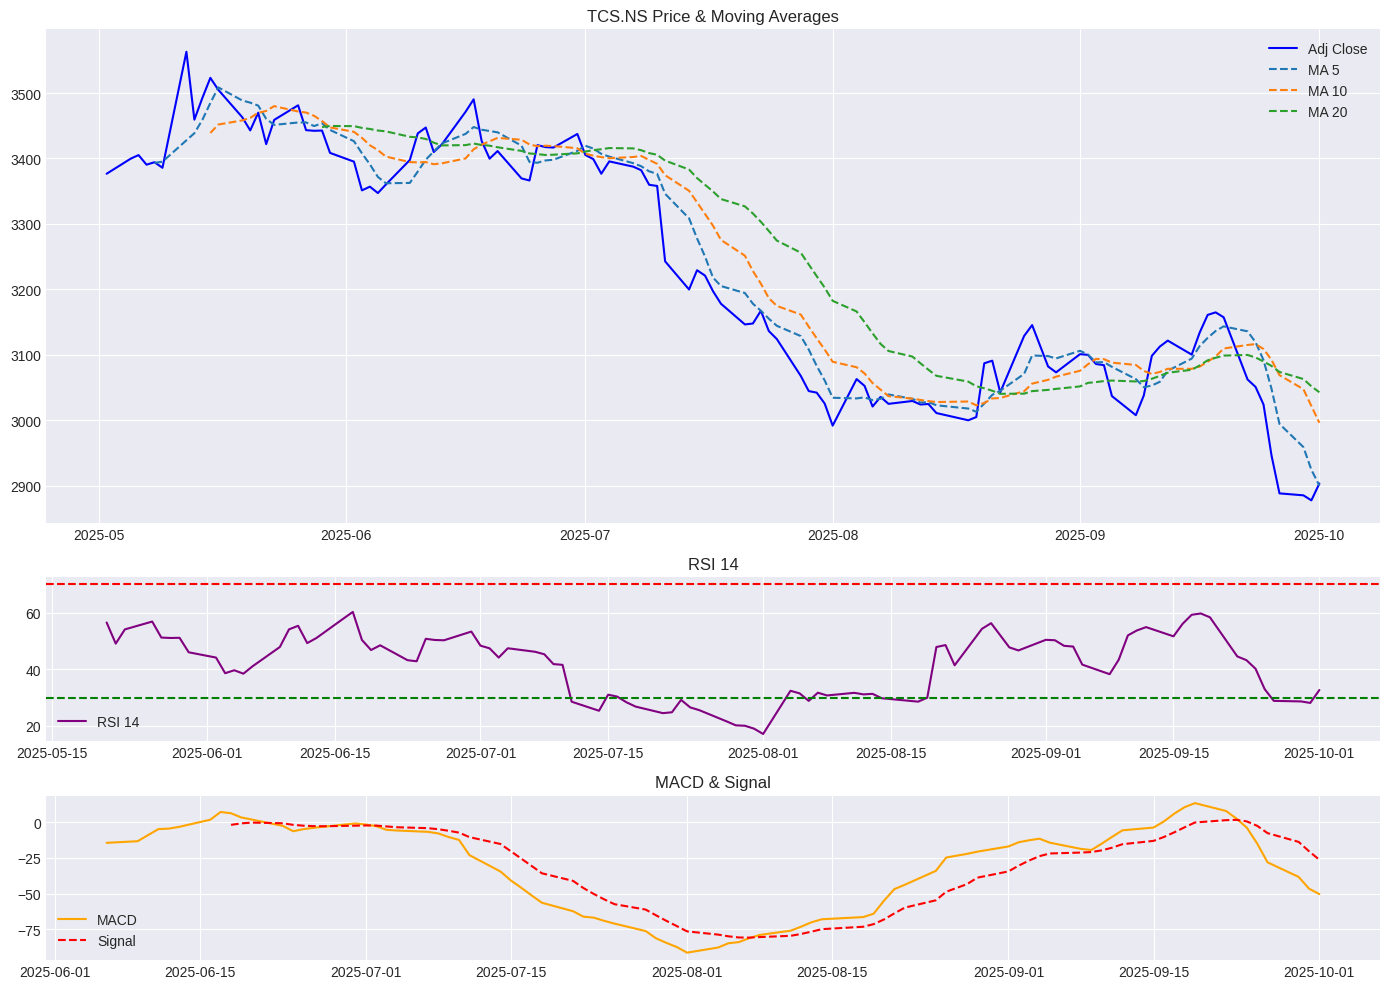

In [19]:
predict_and_plot_stock('TCS.NS', start_date='2025-05-01', end_date='2025-10-01')

In [10]:
def prepare_test_df(ticker, model, scaler, le, seq_len=30):
    df_sub = df_feat[df_feat['Ticker'] == ticker].copy().reset_index(drop=True)
    tid = le.transform([ticker])[0]

    X_pred, y_class, y_reg, _, _ = create_sequences_multi(df_sub)
    X_pred = scaler.transform(X_pred.reshape(-1, len(FEATURE_COLS))).reshape(-1, seq_len, len(FEATURE_COLS))
    stock_array = np.full((len(X_pred), 1), tid)

    preds_class, preds_reg = model.predict([X_pred, stock_array], verbose=0)
    preds_class = (preds_class.flatten() > 0.5).astype(int)

    df_test = df_sub.iloc[seq_len:].copy()
    df_test['pred'] = preds_class
    df_test['pred_prob'] = preds_class
    df_test['next_ret'] = df_test['Target_Reg']

    df_test = df_test[['Date', 'Ticker', 'pred', 'pred_prob', 'next_ret']]
    return df_test


In [32]:
df_test = prepare_test_df('TCS.NS', model, scaler, le)
df_test.tail()


Price,Date,Ticker,pred,pred_prob,next_ret
2665,2025-10-17,TCS.NS,0,0,0.017892
2666,2025-10-20,TCS.NS,0,0,-0.002819
2667,2025-10-21,TCS.NS,0,0,0.022117
2668,2025-10-23,TCS.NS,0,0,-0.003254
2669,2025-10-24,TCS.NS,0,0,-0.878101


In [33]:
# Evaluation & Strategy Simulation utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean

plt.style.use('seaborn-v0_8-darkgrid')

def simulate_strategy(df, initial_capital=100000.0, transaction_cost=0.0005):
    """
    Simulate a strategy where:
      - if df['pred'] == 1 -> invest full capital for the next day
      - if df['pred'] == 0 -> stay in cash (no exposure)
    transaction_cost is a fraction applied once per round-trip approximated per trade (simple approximation).
    Returns: dataframe with equity curves and daily returns for strategy & buy_and_hold, and metrics dict.
    """
    df = df.copy().reset_index(drop=False)  # keep a Date column if index not date
    # Ensure cols exist
    if 'next_ret' not in df.columns or 'pred' not in df.columns:
        raise ValueError("df must contain 'next_ret' and 'pred' columns.")

    n = len(df)
    equity = np.zeros(n)
    equity[0] = initial_capital
    cash = initial_capital
    position = 0.0  # 0 or 1 fraction of capital invested
    # We'll simulate day-by-day: for day i, if pred[i] == 1 we enter for next day's return `next_ret[i]`
    # Simpler: apply return at same row: equity[i] = equity[i-1] * (1 + pred[i]*next_ret[i]) - tx_costs_if_trade

    equity_series = []
    daily_ret_strategy = []
    # We will approximate transaction cost: if we switch from cash->invested or invested->cash we charge cost
    prev_pos = 0
    for i in range(n):
        pred = int(df.loc[i, 'pred'])
        r = float(df.loc[i, 'next_ret'])
        # Determine trades: if prev_pos == 0 and pred == 1 => buy (charge tx cost)
        # if prev_pos ==1 and pred == 0 => sell (charge tx cost)
        tx_cost = 0.0
        if pred != prev_pos:
            # we change position -> approximate round-trip cost = transaction_cost * equity
            # but to be conservative charge single transaction cost now
            tx_cost = transaction_cost * equity[i-1] if i>0 else transaction_cost * initial_capital
        # apply return if in position
        if i == 0:
            prev_equity = initial_capital
        else:
            prev_equity = equity[i-1]
        if pred == 1:
            new_equity = prev_equity * (1 + r) - tx_cost
            daily_ret = (new_equity - prev_equity) / prev_equity
        else:
            # remain in cash: small interest ignored (0%); only reduce by tx cost if we sold today
            new_equity = prev_equity - tx_cost
            daily_ret = (new_equity - prev_equity) / prev_equity
        equity[i] = new_equity
        daily_ret_strategy.append(daily_ret)
        equity_series.append(new_equity)
        prev_pos = pred

    df['strategy_equity'] = equity_series
    df['strategy_daily_ret'] = daily_ret_strategy

    # Buy & Hold (B&H) equity starting at same capital, invest on first day, hold every day
    bh_eq = initial_capital * np.cumprod(1 + df['next_ret'].values)
    df['bh_equity'] = bh_eq
    df['bh_daily_ret'] = df['next_ret'].values

    # Metrics
    def calc_metrics(equity_series, daily_returns):
        total_return = equity_series[-1] / equity_series[0] - 1
        days = len(equity_series)
        annual_factor = 252  # trading days approx
        cagr = (equity_series[-1] / equity_series[0]) ** (annual_factor / days) - 1
        ann_vol = np.std(daily_returns) * np.sqrt(annual_factor)
        ann_return = np.mean(daily_returns) * annual_factor
        sharpe = (ann_return / (ann_vol + 1e-12))
        running_max = np.maximum.accumulate(equity_series)
        drawdown = (equity_series - running_max) / running_max
        max_dd = drawdown.min()
        return {
            'total_return': total_return,
            'CAGR': cagr,
            'annualized_return': ann_return,
            'annualized_vol': ann_vol,
            'sharpe': sharpe,
            'max_drawdown': max_dd
        }

    strat_metrics = calc_metrics(df['strategy_equity'].values, df['strategy_daily_ret'].values)
    bh_metrics = calc_metrics(df['bh_equity'].values, df['bh_daily_ret'].values)

    # Trade-level stats
    trades = df[df['pred']==1]
    wins = trades[trades['next_ret']>0]
    win_rate = len(wins) / (len(trades) + 1e-12)
    avg_ret_per_trade = trades['next_ret'].mean() if len(trades)>0 else 0.0

    stats = {
        'initial_capital': initial_capital,
        'n_days': n,
        'n_trades': int(trades.shape[0]),
        'win_rate': win_rate,
        'avg_ret_per_trade': avg_ret_per_trade,
        'strategy': strat_metrics,
        'buy_and_hold': bh_metrics
    }

    return df.set_index('Date' if 'Date' in df.columns else df.index), stats

# Plotting function
def plot_performance(df, stats, figsize=(14,8)):
    fig, axes = plt.subplots(2,2, figsize=figsize, gridspec_kw={'height_ratios':[2,1]})
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[1,0]
    # Equity curve
    ax1.plot(df.index, df['strategy_equity'], label='Strategy Equity', linewidth=2)
    ax1.plot(df.index, df['bh_equity'], label='Buy & Hold Equity', linewidth=2)
    ax1.set_title("Equity Curve: Strategy vs Buy & Hold")
    ax1.legend()
    ax1.set_ylabel("Equity")
    # Drawdowns
    running_max = np.maximum.accumulate(df['strategy_equity'].values)
    drawdown = (df['strategy_equity'].values - running_max) / running_max
    ax2.plot(df.index, drawdown, color='red')
    ax2.fill_between(df.index, drawdown, 0, color='red', alpha=0.2)
    ax2.set_title(f"Strategy Drawdown (max dd = {stats['strategy']['max_drawdown']:.2%})")
    ax2.set_ylabel("Drawdown")
    # Daily returns histogram
    ax3.hist(df['strategy_daily_ret'].dropna(), bins=40)
    ax3.set_title("Strategy daily returns distribution")
    ax3.set_xlabel("Daily return")
    # Scatter predicted prob vs actual next_ret
    ax4 = axes[1,1]
    if 'pred_prob' in df.columns:
        ax4.scatter(df['pred_prob'], df['next_ret'], alpha=0.6, s=20)
        ax4.set_xlabel("Predicted probability")
        ax4.set_ylabel("Actual next-day return")
        ax4.set_title("Predicted prob vs Actual next-day return")
    else:
        ax4.text(0.1,0.5,"No 'pred_prob' column present", fontsize=12)
        ax4.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# df_test must exist and include Date index or Date column, and columns: next_ret, pred, pred_prob (optional)
# For demonstration, call:
# sim_df, stats = simulate_strategy(df_test, initial_capital=100000, transaction_cost=0.0005)
# print(stats)
# plot_performance(sim_df, stats)


Strategy metrics: {'total_return': np.float64(1.6007511851921201), 'CAGR': np.float64(0.09552695522137822), 'annualized_return': np.float64(0.10782228019072869), 'annualized_vol': np.float64(0.1727536919949027), 'sharpe': np.float64(0.624138789423302), 'max_drawdown': np.float64(-0.23066399145336247)}
Buy & Hold metrics: {'total_return': np.float64(-0.6355026514795403), 'CAGR': np.float64(-0.0918413253338154), 'annualized_return': np.float64(0.049612543752730213), 'annualized_vol': np.float64(0.35774845900060476), 'sharpe': np.float64(0.13867996494293122), 'max_drawdown': np.float64(-0.9149421690867734)}
Number of trades: 1254 Win rate: 0.5191387559808609


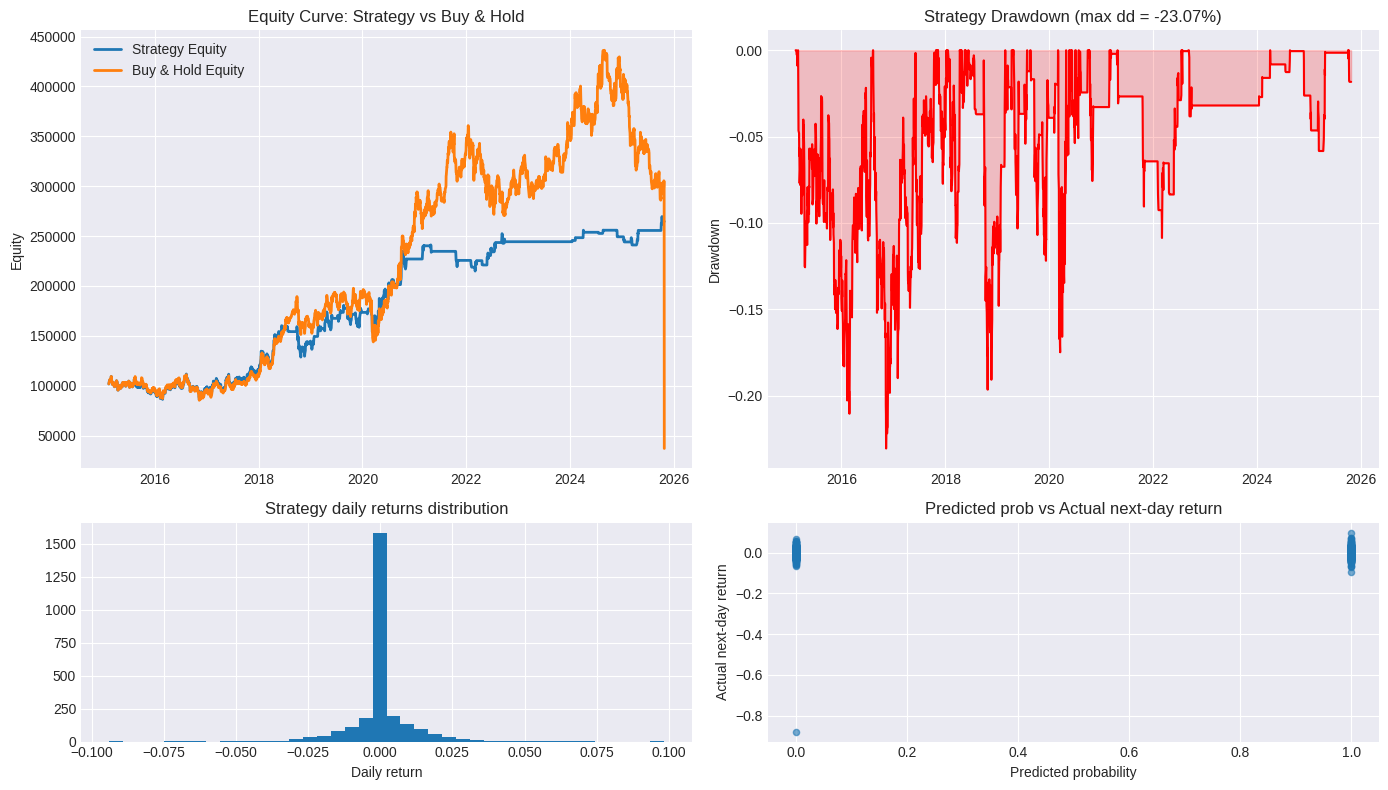

In [34]:
# After predictions
df_test = df_test  # (your test dataframe aligned with predictions)
# Make sure it has Date index
sim_df, stats = simulate_strategy(df_test, initial_capital=100000, transaction_cost=0.0005)
print("Strategy metrics:", stats['strategy'])
print("Buy & Hold metrics:", stats['buy_and_hold'])
print("Number of trades:", stats['n_trades'], "Win rate:", stats['win_rate'])
plot_performance(sim_df, stats)


In [15]:
# Save in TensorFlow's SavedModel format
model.save('multi_stock_lstm_model.keras')

# OR save as a single HDF5 file
model.save('multi_stock_lstm_model.h5')

In [35]:
def simulate_strategy_date_range(df, start_date=None, end_date=None, initial_capital=100000.0, transaction_cost=0.0005):
    """
    Simulate strategy in a specific date range.

    Parameters:
    - df: dataframe with 'Date', 'pred', 'next_ret'
    - start_date, end_date: optional strings 'YYYY-MM-DD'
    - initial_capital: starting equity
    - transaction_cost: fraction per trade

    Returns:
    - df with strategy and B&H equity
    - stats dict
    """
    df_sim = df.copy()

    # Filter by date
    if start_date:
        df_sim = df_sim[df_sim['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_sim = df_sim[df_sim['Date'] <= pd.to_datetime(end_date)]

    df_sim = df_sim.reset_index(drop=True)

    return simulate_strategy(df_sim, initial_capital=initial_capital, transaction_cost=transaction_cost)


def plot_performance_date_range(df, stats, start_date=None, end_date=None, figsize=(14,8)):
    """
    Plot performance only in a specific date range.
    """
    df_plot = df.copy()
    if start_date:
        df_plot = df_plot[df_plot.index >= pd.to_datetime(start_date)]
    if end_date:
        df_plot = df_plot[df_plot.index <= pd.to_datetime(end_date)]

    plot_performance(df_plot, stats, figsize=figsize)


def strategy_metrics_tables(stats):
    import pandas as pd

    # Table 1: Performance Metrics
    perf_data = {
        'Metric': [
            'Total Return', 'CAGR', 'Annualized Return', 'Annualized Volatility',
            'Sharpe Ratio', 'Max Drawdown'
        ],
        'Strategy': [
            f"{stats['strategy']['total_return']*100:.2f}%",
            f"{stats['strategy']['CAGR']*100:.2f}%",
            f"{stats['strategy']['annualized_return']*100:.2f}%",
            f"{stats['strategy']['annualized_vol']*100:.2f}%",
            f"{stats['strategy']['sharpe']:.2f}",
            f"{stats['strategy']['max_drawdown']*100:.2f}%"
        ],
        'Buy & Hold': [
            f"{stats['buy_and_hold']['total_return']*100:.2f}%",
            f"{stats['buy_and_hold']['CAGR']*100:.2f}%",
            f"{stats['buy_and_hold']['annualized_return']*100:.2f}%",
            f"{stats['buy_and_hold']['annualized_vol']*100:.2f}%",
            f"{stats['buy_and_hold']['sharpe']:.2f}",
            f"{stats['buy_and_hold']['max_drawdown']*100:.2f}%"
        ]
    }
    perf_table = pd.DataFrame(perf_data)

    # Table 2: Trade Stats
    trade_data = {
        'Metric': ['Number of Trades', 'Win Rate', 'Avg Return/Trade'],
        'Strategy': [
            stats['n_trades'],
            f"{stats['win_rate']*100:.2f}%",
            f"{stats['avg_ret_per_trade']*100:.2f}%"
        ]
    }
    trade_table = pd.DataFrame(trade_data)

    return perf_table, trade_table



Strategy metrics: {'total_return': np.float64(0.025473041910431427), 'CAGR': np.float64(0.03429194119260659), 'annualized_return': np.float64(0.03519397025149607), 'annualized_vol': np.float64(0.054478205675133354), 'sharpe': np.float64(0.6460192624683743), 'max_drawdown': np.float64(-0.0329866565112806)}
Buy & Hold metrics: {'total_return': np.float64(-0.2835580222886862), 'CAGR': np.float64(-0.36044051054479287), 'annualized_return': np.float64(-0.4050109637917875), 'annualized_vol': np.float64(0.2058834235115393), 'sharpe': np.float64(-1.9671858806404605), 'max_drawdown': np.float64(-0.3060601521979259)}
Number of trades: 15 Win rate: 0.5333333333332978


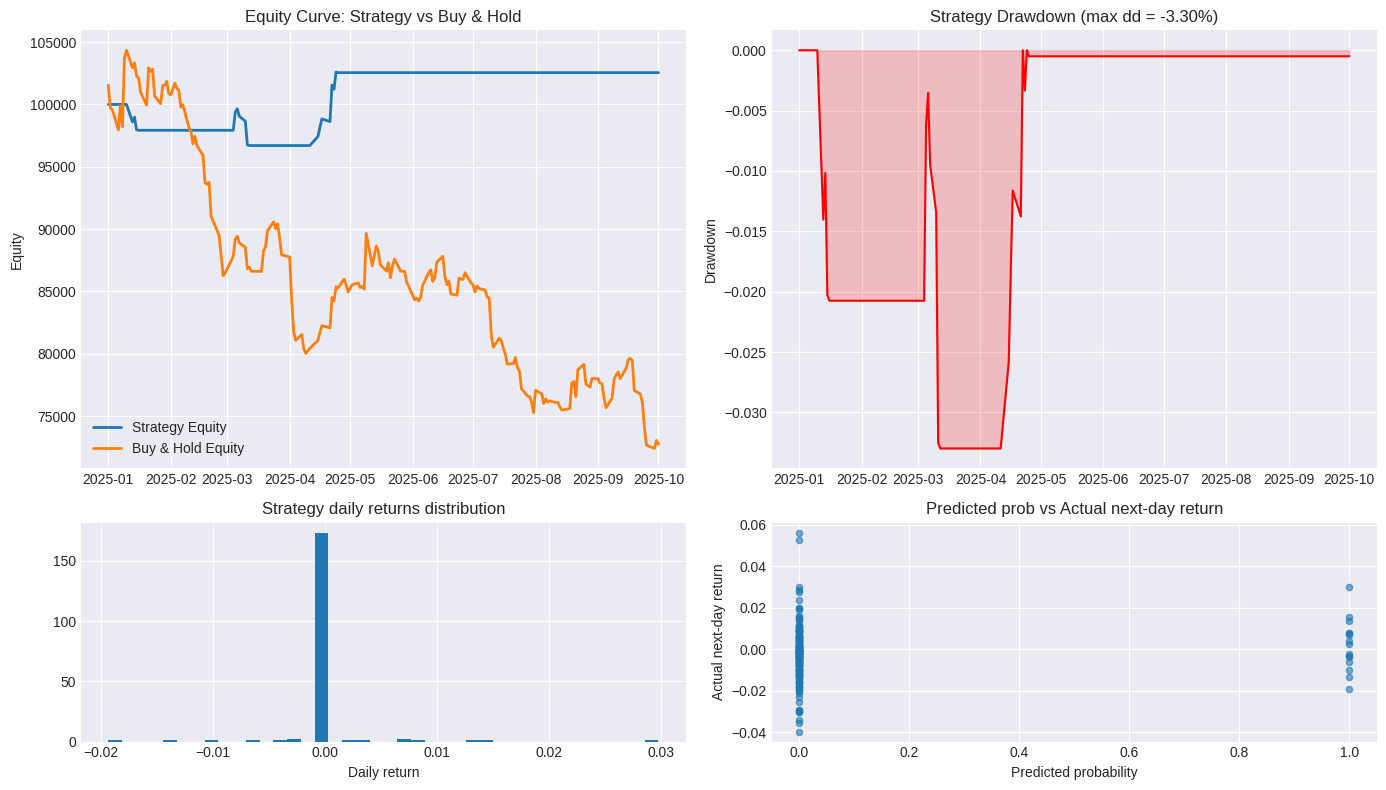

In [36]:
# Simulate and plot strategy for HDFCBANK in 2025 only
sim_df, stats = simulate_strategy_date_range(
    df_test,
    start_date='2025-01-01',
    end_date='2025-10-01',
    initial_capital=100000,
    transaction_cost=0.0005
)

print("Strategy metrics:", stats['strategy'])
print("Buy & Hold metrics:", stats['buy_and_hold'])
print("Number of trades:", stats['n_trades'], "Win rate:", stats['win_rate'])

plot_performance_date_range(sim_df, stats, start_date='2025-01-01', end_date='2025-10-01')


In [37]:
perf_table, trade_table = strategy_metrics_tables(stats)

print("📊 Performance Metrics:")
display(perf_table)

print("\n📋 Trade Stats:")
display(trade_table)

📊 Performance Metrics:


,Metric,Strategy,Buy & Hold
0,Total Return,2.55%,-28.36%
1,CAGR,3.43%,-36.04%
2,Annualized Return,3.52%,-40.50%
3,Annualized Volatility,5.45%,20.59%
4,Sharpe Ratio,0.65,-1.97
5,Max Drawdown,-3.30%,-30.61%



📋 Trade Stats:


,Metric,Strategy
0,Number of Trades,15
1,Win Rate,53.33%
2,Avg Return/Trade,0.20%
